# **Pré-requisitos**

## **Modelagem de Tópicos:**
Após a limpeza e pré-processamento dos dados, a próxima etapa é a modelagem de tópicos. A modelagem de tópicos é um método de aprendizado não supervisionado que ajuda a descobrir tópicos ocultos em grandes volumes de texto. Utilizamos o algoritmo Latent Dirichlet Allocation (LDA), uma técnica popular de modelagem de tópicos que assume que cada documento é uma mistura de vários tópicos.

O LDA é implementado usando a biblioteca Gensim, uma biblioteca Python especializada em modelagem de tópicos e recuperação de informações. Gensim inclui implementações eficientes e escalonáveis de vários algoritmos de modelagem de tópicos, incluindo LDA. A implementação do LDA em Gensim usa aprendizado online, o que o torna capaz de lidar com grandes volumes de dados que não cabem na memória.

O processo envolve a conversão dos dados de texto em um formato que pode ser processado pelo algoritmo LDA. Isso envolve a criação de um dicionário (um mapeamento de palavras para IDs numéricos) e um corpus (uma representação dos documentos em termos dos IDs de palavras e suas contagens).

Depois que o modelo LDA é treinado nos dados, ele pode ser usado para inferir a distribuição de tópicos para novos documentos, ou para encontrar os tópicos mais importantes em todo o conjunto de dados. O número de tópicos é um hiperparâmetro que pode ser ajustado para obter os melhores resultados.

Para visualizar os resultados da modelagem de tópicos, utilizamos a biblioteca pyLDAvis, que fornece uma maneira interativa de explorar os tópicos identificados pelo modelo LDA. A visualização permite examinar a distribuição de palavras em cada tópico e a distribuição de tópicos em cada documento.

Os tópicos identificados pelo modelo LDA podem então ser usados para agrupar leis similares e identificar aquelas que podem ser unificadas ou revogadas. Assim, a modelagem de tópicos fornece uma ferramenta valiosa para a simplificação da legislação municipal.

<hr/>

In [2]:
# Instalar dependências do python
%pip install gensim
%pip install pyLDAvis
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importar bibliotecas necessárias para este projeto
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, CoherenceModel
from gensim.models.ldamodel import LdaModel
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns

# **Analisando termos**

In [4]:
# Carregar o dataset mais atual
df = pd.read_csv('data/Leis de Sorocaba (Preprocessed).csv')

In [5]:
df

,summary
0,dispõe sobre denominação josé antonio pascoto ...
1,dispõe sobre denominação vitor hage via públic...
2,dispõe sobre denominação lisardo cunha dias vi...
3,dispõe sobre denominação desirre ferraz cardos...
4,institui calendário oficial município dia soci...
...,...
12807,dispõe sobre abertura crédito especial $ TOKEN...
12808,dispõe sobre concessão auxílio dá outras provi...
12809,dispõe sobre concessão licença prêmio funcioná...
12810,dispõe sobre apreensão eliminação animais


In [6]:
# Exibir as 30 palavras mais frequentes no corpus
def plot_30_most_frequent_words(words):
  counter = Counter(words.split())
  most_frequent = counter.most_common(30)

  # Fazer um gráfico de barras das palavras frequentes
  fig = plt.figure(1, figsize = (20,10))
  _ = pd.DataFrame(most_frequent, columns=("words","count"))
  sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
  plt.xticks(rotation=45);

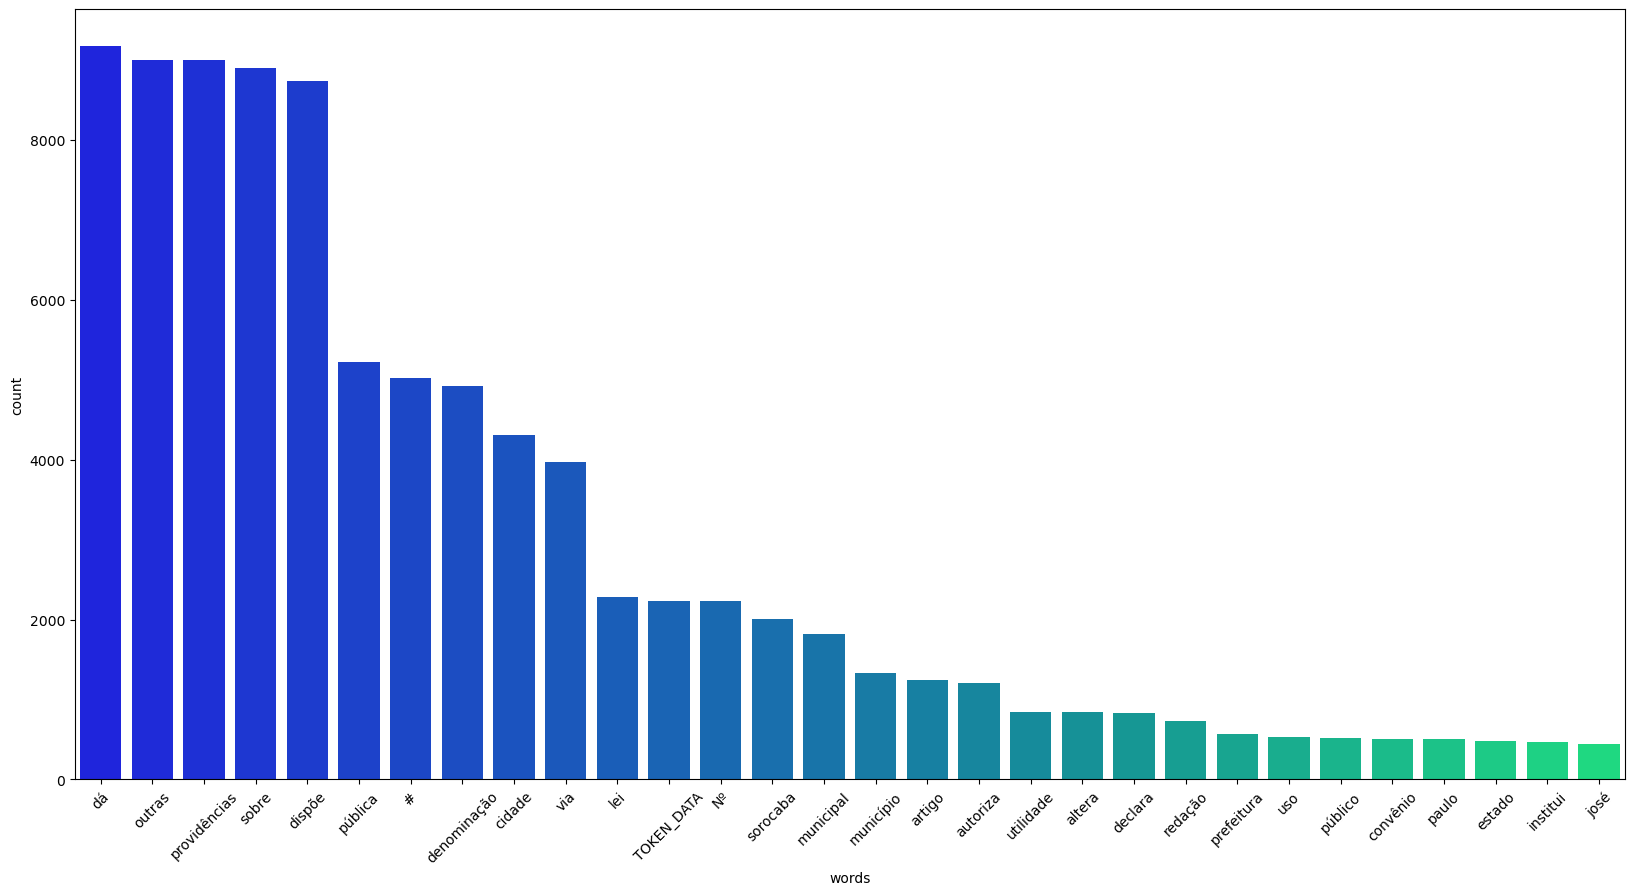

In [7]:
# Unir todas as palavras do corpus
summary_words = ' '.join(list(df['summary'].fillna('').values))

plot_30_most_frequent_words(summary_words)

Parece que temos termos que são muito frequentes e que não adicionam contexto às nossas leis.

Poderíamos removê-los, para melhorar nossa análise.

In [8]:
df['summary'].str.contains('dispõe sobre').sum()

8662

In [9]:
df['summary'].str.contains('dá outras providências').sum()

8887

In [10]:
# Lista de frases a serem removidas
remove_phrases = ['dispõe sobre', 'dá outras providências']

# Junta as frases com o operador OR para o regex
remove_phrases_regex = '|'.join(remove_phrases)

# Remove as frases
df['summary'] = df['summary'].str.replace(remove_phrases_regex, ' ', regex=True).str.strip()

In [11]:
df

,summary
0,denominação josé antonio pascoto via pública
1,denominação vitor hage via pública
2,denominação lisardo cunha dias via pública
3,denominação desirre ferraz cardoso via pública...
4,institui calendário oficial município dia soci...
...,...
12807,abertura crédito especial $ TOKEN_VALOR
12808,concessão auxílio
12809,concessão licença prêmio funcionários municipais
12810,apreensão eliminação animais


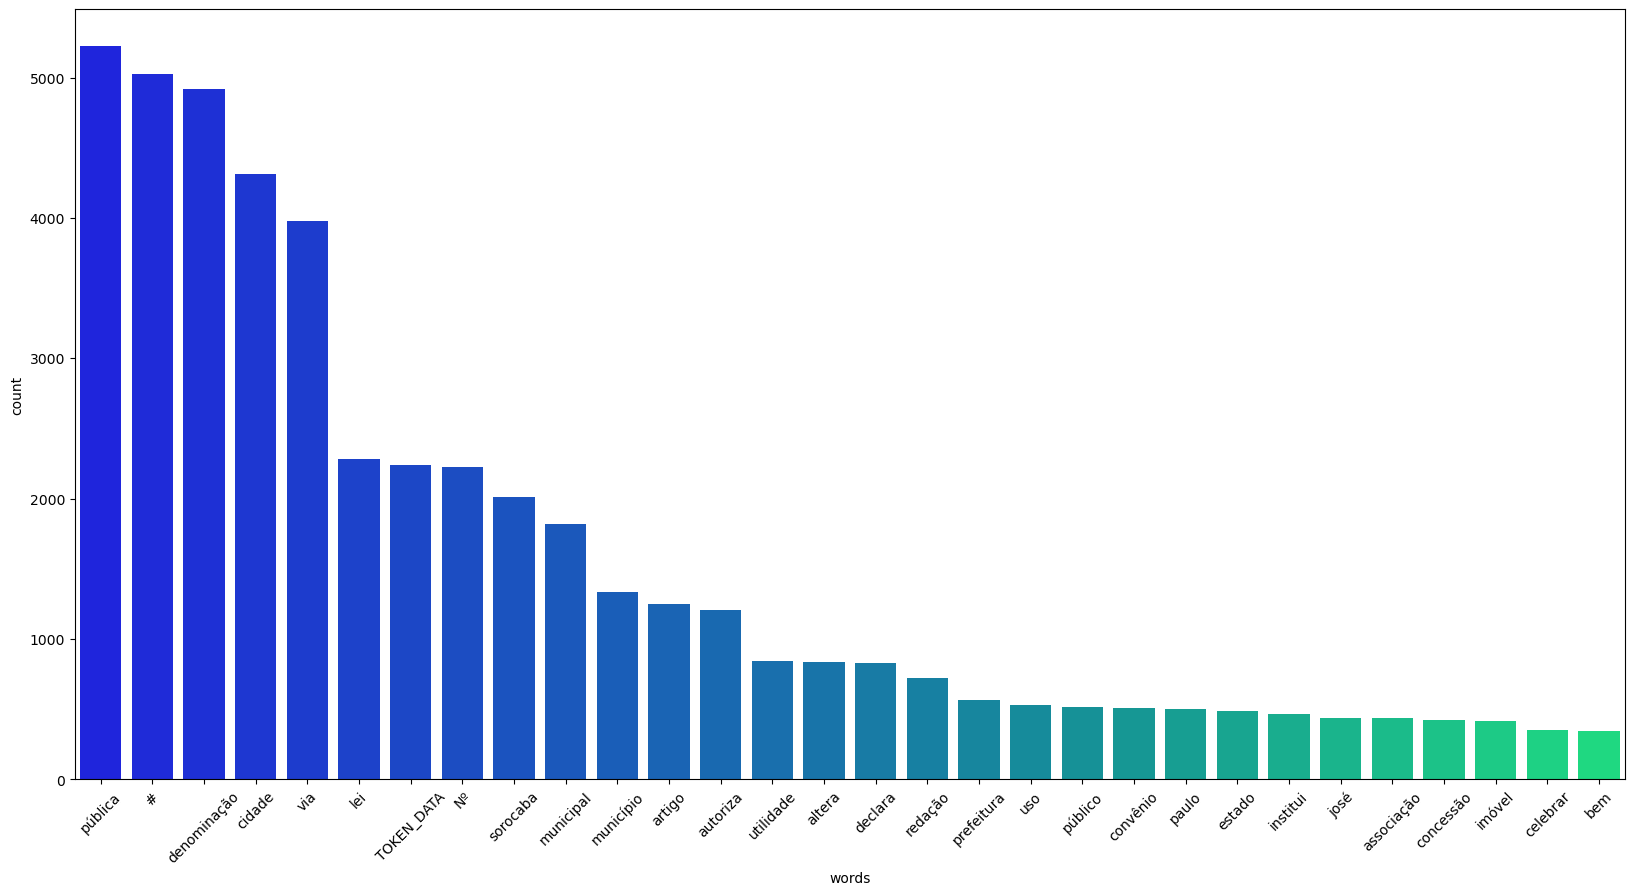

In [12]:
# Exibir novamente as 30 palavras mais frequentes
summary_words = ' '.join(list(df['summary'].fillna('').values))

plot_30_most_frequent_words(summary_words)

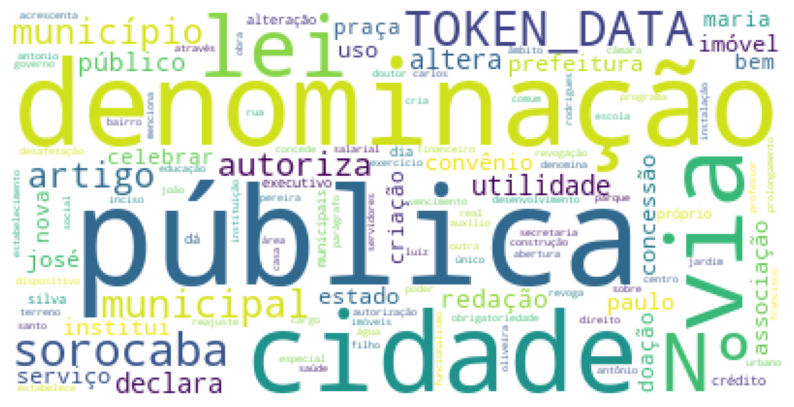

In [13]:
# Fazer uma núvem de palavras da legislação de Sorocaba
wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(summary_words)

fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# **Modelagem de Tópicos**

In [14]:
words_vec = list(df['summary'].fillna('').str.split())

In [15]:
words_vec[:5]

[['denominação', 'josé', 'antonio', 'pascoto', 'via', 'pública'],
 ['denominação', 'vitor', 'hage', 'via', 'pública'],
 ['denominação', 'lisardo', 'cunha', 'dias', 'via', 'pública'],
 ['denominação', 'desirre', 'ferraz', 'cardoso', 'via', 'pública', 'cidade'],
 ['institui', 'calendário', 'oficial', 'município', 'dia', 'sociólogo']]

In [16]:
dct = Dictionary(words_vec)
corpus = [dct.doc2bow(line) for line in words_vec]
model = TfidfModel(corpus)

In [17]:
vector = model[corpus[0]]

In [18]:
vector

[(0, 0.38553281191686256),
 (1, 0.0866783170351874),
 (2, 0.30534224389337555),
 (3, 0.8560399328506776),
 (4, 0.08128336859310314),
 (5, 0.10585878206718695)]

In [19]:
# Exibir TF-IDF de cada palavra
{dct.get(id): value for id, value in vector}

{'antonio': 0.38553281191686256,
 'denominação': 0.0866783170351874,
 'josé': 0.30534224389337555,
 'pascoto': 0.8560399328506776,
 'pública': 0.08128336859310314,
 'via': 0.10585878206718695}

<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

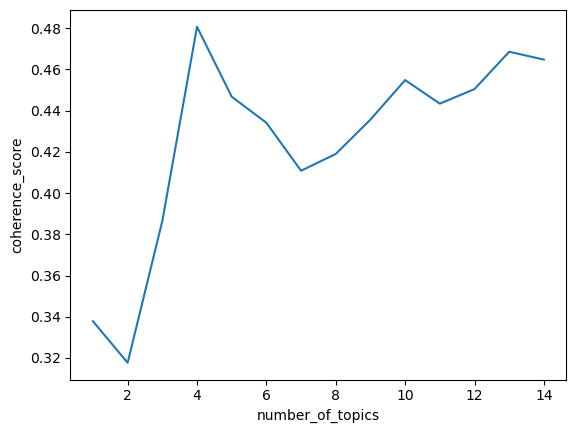

In [20]:
# Calcular a nota de coerência
number_of_topics = []
coherence_score = []
for i in range(1,15):
  lda_model = LdaModel(corpus=corpus,
                    id2word=dct,
                    iterations=50,
                    num_topics=i,
                    random_state=42)
  coherence_model_lda = CoherenceModel(model=lda_model,
                                       texts=words_vec,
                                       dictionary=dct,
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Criar um dataframe de nota de coerência por número de tópicos
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Exibir um gráfico de linha
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [24]:
# Definir o número de tópicos
n_topics = 13

# Rodar o modelo LDA
lda_model = LdaModel(corpus=corpus,
                    id2word=dct,
                    num_topics=n_topics,
                    random_state=42,
                    update_every=1,
                    passes=10,
                    alpha='symmetric',
                    iterations=100,
                    per_word_topics=True)

In [25]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.168*"pública" + 0.167*"denominação" + 0.160*"cidade" + 0.152*"via" + 0.018*"denomina" + 0.016*"josé" + 0.011*"praça" + 0.010*"maria" + 0.009*"silva" + 0.008*"joão"
Topic: 1 Word: 0.111*"abertura" + 0.059*"municipal" + 0.046*"reajuste" + 0.046*"vencimentos" + 0.038*"funcionalismo" + 0.033*"público" + 0.032*"concessão" + 0.030*"câmara" + 0.027*"públicas" + 0.025*"vias"
Topic: 2 Word: 0.062*"autoriza" + 0.060*"imóvel" + 0.056*"uso" + 0.049*"doação" + 0.049*"estado" + 0.047*"paulo" + 0.031*"bem" + 0.028*"construção" + 0.027*"desapropriação" + 0.023*"desafetação"
Topic: 3 Word: 0.108*"pública" + 0.107*"utilidade" + 0.101*"declara" + 0.069*"sorocaba" + 0.047*"associação" + 0.025*"município" + 0.018*"#" + 0.016*"exercício" + 0.016*"sociedade" + 0.015*"fixa"
Topic: 4 Word: 0.086*"municipais" + 0.055*"servidores" + 0.038*"instituto" + 0.038*"serviço" + 0.038*"água" + 0.037*"funcionários" + 0.034*"públicos" + 0.023*"aquisição" + 0.020*"concessão" + 0.018*"sorocaba"
Topic: 5 Word

In [26]:
# Import and enable notebook to run visualization
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model,
                                     corpus,
                                     dct, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.377193 -0.170765       1        1  22.905976
8      0.208715  0.372567       2        1  17.159848
5     -0.107278 -0.012387       3        1  11.016458
3      0.168858 -0.069967       4        1   7.916893
2     -0.104331  0.115585       5        1   7.517520
7     -0.105238  0.123383       6        1   6.302375
10    -0.079841 -0.080351       7        1   5.336798
9     -0.077828 -0.049118       8        1   4.129259
12    -0.055737 -0.049672       9        1   4.007798
1     -0.079377 -0.046412      10        1   3.934663
6     -0.023258 -0.088866      11        1   3.333412
11    -0.043480 -0.000761      12        1   3.293226
4     -0.078397 -0.043236      13        1   3.145774, topic_info=             Term         Freq        Total Category  logprob  loglift
21              #  4934.000000  4934.000000  Default  30.0000  30.0000
4         pública  5355.000000  5355.000000  Default  29.0000  29.0000
12         cidade  4182.000000  4182.000000  Default  28.0000  28.0000
1     denominação  4426.000000  4426.000000  Default  27.0000  27.0000
5             via  3976.000000  3976.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
281     concessão    73.216576   486.299765  Topic13  -3.8909   1.5657
1532   benefícios    22.640665    36.259263  Topic13  -5.0646   2.9882
35       sorocaba    64.363989  1889.422465  Topic13  -4.0198   0.0796
1256       quadro    22.654149    79.349351  Topic13  -5.0640   2.2056
81         social    25.097453   195.513559  Topic13  -4.9616   1.4062

[561 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
21        2  0.967074       #
21        4  0.032628       #
3801      1  0.991992       $
850       9  0.959715       %
3664      8  0.955390       .
...     ...       ...     ...
55        3  0.011229  âmbito
55        7  0.909533  âmbito
55        8  0.067373  âmbito
531       7  0.979710  ônibus
871       2  0.992368   único

[640 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 6, 4, 3, 8, 11, 10, 13, 2, 7, 12, 5])

Apesar de termos construído um modelo bastante simplificado, analisando somente a ementa das leis, pudemos fazer uma modelagem de tópicos bastante interessante.

É possível identificar alguns grupos claros:

* Denominações de logradouros públicos, como vias, ruas e praças
* Alteração ou revogação de outras leis
* Declarações de instituições como sendo de utilidade pública
* Autorização de convênio com instituições e outros órgãos públicos
* Concessão de créditos e remunerações

Tudo indica que, com uma maior dedicação, há grande possibilidade de construirmos um modelo satisfatório para analisar leis que podem ser revogadas ou unificadas.